# Risk Measures

This notebook illustrates the *Value at Risk* (VaR) and *Expected Shortfall*. To improve the performance, a model for time-varying risk is estimated and incorporated into the calculations. The model is backtested on a data set.

We use the the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package to calculate probability values and quantiles.

## Load Packages and Extra Functions

In [1]:
using Printf, Dates, Distributions, DelimitedFiles

include("src/printmat.jl");

In [2]:
using Plots
default(size = (480,320),fmt = :png)

# Value at Risk (VaR) for a N(μ,σ²) Return

$\textrm{VaR}_{95\%} = - (5^{th}$ percentile of the return distribution)

With a $N(\mu,\sigma^2)$ distribution this gives approximately

$\textrm{VaR}_{95\%} \approx - (\mu-1.64\sigma)$

### A Remark on the Code
- The Distributions.jl package defines a normal distribution as `Normal(μ,σ)`. Notice that it uses the standard deviation, not the variance. For instance, to calculate the 5th quantile, use `quantile(Normal(μ,σ),0.05)` and to calculate the pdf value at each element of a vector `x`, use `pdf.(Normal(μ,σ),x)`.

In [3]:
"""
    VaRNormal(μ,σ,α)

Calculate VaR at a confidence level α (eg. 0.95) from a N() distribution with mean μ and standard deviation σ. 
"""
function VaRNormal(μ,σ,α) 
    c   = quantile(Normal(0,1),1-α)
    VaR = -(μ + c*σ)             #same as -quantile(Normal(μ,σ),1-α)
    return VaR
end

VaRNormal

In [4]:
(μ,σ) = (8,16)

VaR_b = -(μ - 1.64*σ)
VaR   =  VaRNormal(μ,σ,0.95)

printblue("with μ=$μ and σ=$σ, we have approximately:\n")
printmat([μ - 1.64485*σ,VaR_b,VaR];rowNames=["5th quantile","≈ VaR 95%","VaR 95%"])

with μ=8 and σ=16, we have approximately:

5th quantile   -18.318
≈ VaR 95%       18.240
VaR 95%         18.318



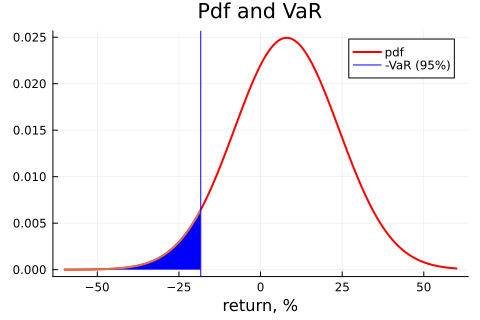

In [5]:
R    = range(-60,60,length=301)
pdfR = pdf.(Normal(μ,σ),R)
Rb   = R[R .<= -VaR]             #or filter(<=(-VaR₉₅),R)

p1 = plot( R,pdfR,
           linecolor = :red,
           linewidth = 2,
           label = "pdf",
           title = "Pdf and VaR",
           xlabel = "return, %" )
plot!(Rb,pdf.(Normal(μ,σ),Rb),fillcolor=:red,linewidth=2,fill=(0,:blue),label="")
vline!([-VaR],linecolor=:blue,label="-VaR (95%)")
display(p1)

# Loading Daily S&P 500 Data

### Remark on the Code

The first column of the data file contains dates in the form `02/01/1979`, which will be interpreted as strings. The `x` matrix will an `Any` matrix, so that it can hold both strings and numbers. For this reason, we convert the numerical columns to floating point numbers. This is not strictly necessary, but might speed up some calculations. 

(Other packages, eg. [CSV.jl](https://github.com/JuliaData/CSV.jl), might do a better job in detecting the type(s) of the data.)

In [6]:
x  = readdlm("Data/SP500RfPs.csv",',',skipstart=1)
SP = convert.(Float64,x[:,2])             #S&P 500 level
R  = (SP[2:end]./SP[1:end-1] .- 1)*100    #returns, %
T  = length(R)

dN = Date.(x[2:end,1],"d/m/y");    #convert to Date
SP = SP[2:end]

println("Days in the sample: $T")

Days in the sample: 9352


# Backtesting a Static VaR from N() on Data

To backtest a VaR model, we study the relative frequency of loss > VaR, that is of $-R > VaR$.

## Backtesting for the Full Sample

The code below does this for different confidence levels (0.95,0.96,...) of the VaR. For instance, at the 0.95 confidence levels we
1. calculate the VaR as the (negative of the) 0.05 quantile of a normal distribution (with the mean and std estimated from the sample, which is just one possible choice)
2. count the relative frequency of the loss > VaR (it should be 0.05).

Then repeat for other confidence levels, eg. 0.96.

In [7]:
μₑₘₚ = mean(R)                       #mean and std of data (empirical)
σₑₘₚ = std(R)

confLev = 0.95:0.005:0.995          #different confidence levels
L       = length(confLev)
loss    = -R

(VaR_L,BreakFreq_L) = (fill(NaN,L),fill(NaN,L))   #for different confidence levels
for i in 1:L                 #loop over confidence levels
    VaR_L[i]       = VaRNormal(μₑₘₚ,σₑₘₚ,confLev[i])
    BreakFreq_L[i] = mean(loss .> VaR_L[i]) #freq of breaking the VaR
end

printblue("Backtesting a static VaR:\n")
printmat([confLev VaR_L BreakFreq_L];colNames=["conf level","N()-based VaR","break freq"],width=18)

printred("The break frequency should be 1-confidence level")

Backtesting a static VaR:

        conf level     N()-based VaR        break freq
             0.950             1.790             0.041
             0.955             1.846             0.037
             0.960             1.907             0.034
             0.965             1.975             0.032
             0.970             2.052             0.029
             0.975             2.140             0.026
             0.980             2.244             0.023
             0.985             2.373             0.019
             0.990             2.547             0.016
             0.995             2.824             0.012

The break frequency should be 1-confidence level


## Backtesting on a Moving Data Window

The code below also studies the relative frequency of loss > VaR, but over a *moving data window* of 100 days. This allows us to investigate if there are long periods of failures of the VaR model. To be parsimonious, we do this for a single confidence level, 0.95.

In [8]:
VaR = VaRNormal(μₑₘₚ,σₑₘₚ,0.95)        #static VAR at 95% confidence level

BreakFreq = fill(NaN,T)                #vector, freq(loss>VaR) on moving data window
for t in 101:T                         #loop over end-points of the data window
    BreakFreq[t] = mean(loss[t-100:t] .> VaR)
end

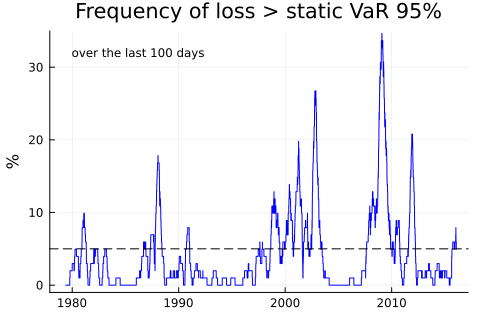

In [9]:
xTicksLoc = [Date(1980);Date(1990);Date(2000);Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN,BreakFreq*100,
           linecolor = :blue,
           ylim = (-1,35),
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           title = "Frequency of loss > static VaR 95%",
           ylabel = "%",
           annotation = (Date(1980),32,text("over the last 100 days",8,:left)) )
hline!([5],linecolor=:black,line=(:dash,1))
display(p1)

# A Simple Dynamic VaR with Time-Varying Volatility

To improve the performance of the VaR model, we combine a simple time series model for volatility with an N()-based VaR calculation.

We first construct an simple estimate of $\sigma_t^2$ and $\mu_t$ as a backward looking exponential moving average (cf. RiskMetrics)

$\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1-\lambda) (R_{t-1} -\mu_{t-1})^2$,
where $\mu_{t}=\lambda \mu_{t-1} + (1-\lambda) R_{t-1}$,

where we use $\lambda \approx 0.94$.

We then redo the $\textrm{VaR}_{95\%}$ calculation using

$\textrm{VaR}_{t} = - (\mu_t-1.64\sigma_t)$

and study if it has better properties than the static VaR.

In [10]:
"""
    EWMA(x,λ,μ_start,σ²_start)

Calculate an EWMA mean and variance
"""
function EWMA(x,λ,μ_start,σ²_start)
    T = length(x)
    (μ,σ²) = (fill(μ_start,T),fill(σ²_start,T))
    for t in 2:T
        μ[t]  = λ*μ[t-1]  + (1-λ)*x[t-1]
        σ²[t] = λ*σ²[t-1] + (1-λ)*(x[t-1]-μ[t-1])^2
    end
    return μ,σ²
end

EWMA

In [11]:
λ = 0.94
(μ,σ²) = EWMA(R,λ,μₑₘₚ,σₑₘₚ^2)               #EWMA estimates of (μ,σ²)

VaRd = VaRNormal.(μ,sqrt.(σ²),0.95);        #VaR for each date 

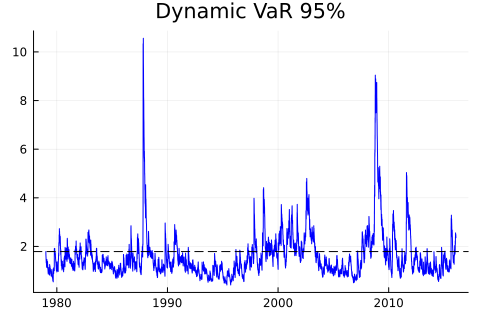

In [12]:
p1 = plot( dN,VaRd,
           linecolor = :blue,
           #ylim = (-1,35),
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           title = "Dynamic VaR 95%",
           ylabel= "",
           annotation = (Date(1980),32,text("over the last 100 days",8,:left)) )
hline!([VaR],linecolor=:black,line=(:dash,1))
display(p1)

In [13]:
BreakFreq = fill(NaN,T)         #backtesting, freq(loss>VaR) on moving data window
for t in 101:T
    BreakFreq[t] = mean(loss[t-100:t] .> VaRd[t-100:t])
end

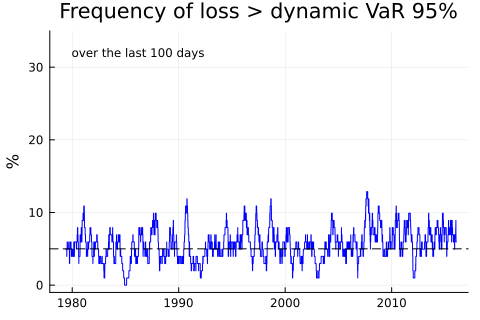

In [14]:
p1 = plot( dN,BreakFreq*100,
           linecolor = :blue,
           ylim = (-1,35),
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           title = "Frequency of loss > dynamic VaR 95%",
           ylabel= "%",
           annotation = (Date(1980),32,text("over the last 100 days",8,:left)) )
hline!([5],linecolor=:black,line=(:dash,1))
display(p1)

# Expected Shortfall

The Expected Shortfall (ES) is the average loss, conditional on exceeding the VaR level. In terms of the returns (not losses) this is

$\text{ES}_{\alpha}=-\text{E}(R|R\leq-\text{VaR}_{\alpha})$

For a normally distributed return $R\sim N(\mu,\sigma^{2})$ we have

$\text{ES}_{95\%}=-\left(\mu - \frac{\phi(-1.64)}{0.05}\sigma\right)$,

where $\phi()$ is the pdf of a $N(0,1)$ variable. For other confidence levels, change -1.64 and 0.05.

Alternatively, we can calculate the ES as 
`-mean(truncated(Normal(μ,σ);upper=q))` where `q` is the quantile of the return distribution.

In [15]:
"""
    ESNormal(μ,σ,α)

Calculate ES at a confidence level α (eg. 0.95) from a N() distribution with 
mean μ and standard deviation σ.

Notice that this can also be calculated as
```
q  = quantile(Normal(μ,σ),1-α)
ES = -mean(truncated(Normal(μ,σ);upper=q))
```

"""
function ESNormal(μ,σ,α) 
    c  = quantile(Normal(0,1),1-α)
    ϕ  = pdf(Normal(0,1),c)    
    ES = -(μ - ϕ*σ/(1-α))
    return ES
end

ESNormal

In [16]:
(μb,σb) = (8,16)
ES =  ESNormal(μb,σb,0.95)

printblue("ES 95% with μ=$μb and σ=$σb is:\n")
printlnPs(ES)

ESd = ESNormal.(μ,sqrt.(σ²),0.95);     #for each date

ES 95% with μ=8 and σ=16 is:

    25.003


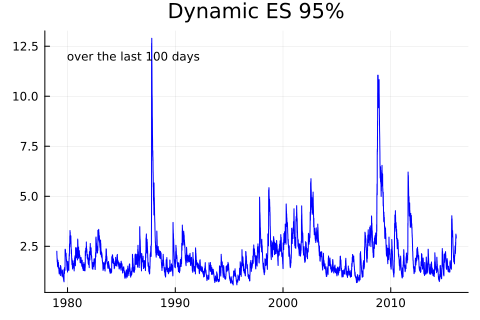

In [17]:
p1 = plot( dN,ESd,
           linecolor = :blue,
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           title = "Dynamic ES 95%",
           ylabel= "",
           annotation = (Date(1980),12,text("over the last 100 days",8,:left)) )
display(p1)

## Backtesting ES

by comparing the empirical average return  (conditional on loss > VaR) with the predictions from the model with $\mathrm{N}(\mu_t,\sigma_t^2)$.

Notice that the interactive dummy $\delta$ means that we are effectively calculating results only for those observations when loss > VaR.

In [18]:
ES_backtest = fill(NaN,T,2)         #backtesting ES
for t in 101:T
  δ                = loss[t-100:t] .> VaRd[t-100:t]         #dummy: 1 if loss > VaR 
  ES_backtest[t,1] = sum(δ.*loss[t-100:t])/sum(δ)           #mean empirical loss|loss>VaR
  ES_backtest[t,2] = sum(δ.*ESd[t-100:t])/sum(δ)            #mean N()-theoretical loss|loss>VaR
end

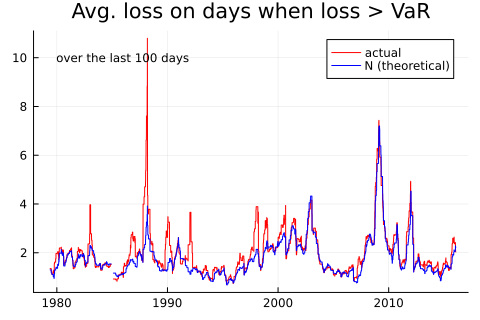

In [19]:
p1 = plot( dN,ES_backtest,
           linecolor = [:red :blue],
           label = ["actual" "N (theoretical)"],
           xticks = (xTicksLoc,xTicksLab),
           title = "Avg. loss on days when loss > VaR",
           ylabel= "",
           annotation = (Date(1980),10,text("over the last 100 days",8,:left)) )
display(p1)

# Target Semi-Variance

The target semi-variance is the average value of `δ.*(x.-h).^2` where `δ[t]=1` if `x[t] <= h` and zero otherwise. The "Sortino" ratio is the ratio of the average `x-h` divided by the square root of the target semi-variance. It is an alternative to the Sharpe ratio.

In [20]:
"""
    TargetSemiVar(x,h)

Calculate target semi-variance
"""
function TargetSemiVar(x,h)
    δ = x .<= h
    TSV = mean( δ.*(x.-h).^2 )    #a function for target semi-variance
    return TSV
end    

TargetSemiVar

In [21]:
TSV = TargetSemiVar(R,0)

printlnPs("Target semi-variance: ",TSV)

Target semi-variance:      0.625


# Maximum Drawdown

is the largest loss that could have been made in a sample, buy buying at the top and selling at the bottom.

In [22]:
"""
    HistMax(x)

Calculate historial max of a data series, up to and including `x[t]`
"""
function HistMax(x)
  T = length(x)
  xMax = fill(x[1],T)
  for t in 2:T
    xMax[t] = max(xMax[t-1],x[t])
  end
  return xMax
end


"""
    Drawdown(x)

Calculate the (relative) drawdown in a sample, compared to an earlier max level

"""
function Drawdown(x)
    x_HistMax = HistMax(x)
    D         = (x_HistMax - x)./x_HistMax         #relative drawdown
    return D, x_HistMax
end;

In [23]:
(D,P_max) =  Drawdown(SP)                      #calculate the relative drawdown

vv1 = argmax(D)                               #index of day with worst drawdown
vv2 = findfirst(==(P_max[vv1]),P_max)         #index of day when the max was reached

printblue("Maximum relative drawdown: $(round(Int,D[vv1]*100))% from $(dN[vv2]) to $(dN[vv1]) \n") 

Maximum relative drawdown: 57% from 2007-10-09 to 2009-03-09 



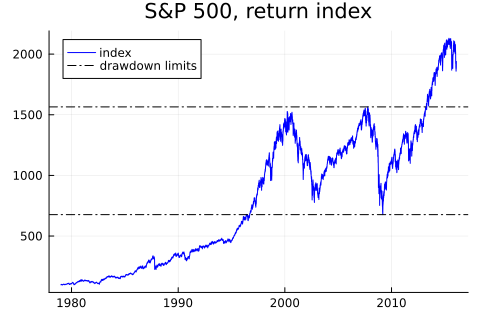

In [24]:
p1 = plot( dN,SP,
           linecolor = :blue,
           #legend = false,
           label = "index",
           xticks = (xTicksLoc,xTicksLab),
           title = "S&P 500, return index",
           ylabel= "" )
hline!(SP[[vv1,vv2]],linecolor=:black,line=:dashdot,label="drawdown limits")
display(p1)